# Material de Geofísica - Obtenção de dados públicos de artigo e tratamento com Python
#### Curso de Geologia - Geofísica Aplicada - 2o Semestre 2024
Profa. Luizemara Szameitat
![Banner USP](https://raw.githubusercontent.com/lszam/geofex/main/assets/img/banner_usp.png)

OBJETIVO: Exercitar a busca, obtenção e análise expedita de dados públicos.

> *Aluno: Insira seu nome na variável "aluno", entre aspas como no exemplo:
aluno = 'Luiz'. A variável "atividade" contém o nome desta atividade. Execute a célula abaixo e as demais clicando no canto superior esquerdo.*

**NOME DO ALUNO:**


In [1]:
###DEIXE O SEU NOME REGISTRADO!!!####

aluno = 'Insira seu nome aqui'

##**1. Obtendo os dados**
* Dados: Lunar Crustal Magnetic Field Map Data Collection (NASA)
* Sistema de observação: Lunar Prospector - Kaguya
Lunar Prospector: https://pds-ppi.igpp.ucla.edu/search/target?t=Earth&sc=Lunar%20Prospector#
> *This collection contains a large-scale map of the lunar crustal magnetic field at 30 km altitude covering latitudes from 65 degrees south to 65 degrees north. This map has been produced using high quality vector magnetometer data from Lunar Prospector and SELENE (Kaguya).*



##**PASSOS**
1.	***Acesse a página do artigo científico relacionado**:
> Hood, L. L., Torres, C. B., Oliveira, J. S., Wieczorek, M. A., & Stewart, S. T. (2021). A new large‐scale map of the lunar crustal magnetic field and its interpretation. Journal of Geophysical Research: Planets, 126(2), e2020JE006667. https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020JE006667

2.	**Acesse a página onde os dados estão disponibilizados**. O link está na página do artigo, nos últimos itens. Em artigos que disponibilizam seus dados, geralmente esta informação está no final em "Data Availability", "Open Research", ou algo do tipo. Entrem, vão clicando, e na página final, onde estão as opções de download, **escolham baixar o arquivo no formato CSV** (*Comma Separated Values*).
>*Como é a janela certa dos dados: https://github.com/lszam/geofex/blob/main/data/Mag_Lua/Salvar_dados_lua.png*

3. **Faça o upload do arquivo CSV ( Bm_30km_65S65N_0E360E.csv ) para este notebook** atravé do menu na lateral esquerda desta página do Colab (ícone de pasta, depois ícone de papel com uma seta para cima).

In [2]:
#Importar as bibliotecas que precisamos
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.fftpack import fft, fftfreq
from scipy.interpolate import griddata

# Carregar dados do arquivo csv
file_path = 'Bm_30km_65S65N_0E360E.csv'
dados = pd.read_csv(file_path)
dados.describe()

,Longitude,Latitude,B-Mag,B-Rad,B-East,B-North
count,140940.000000,140940.000000,140940.000000,140940.000000,140940.000000,140940.000000
mean,179.666672,0.000000,0.982251,0.001786,-0.000286,-0.001116
std,103.923242,37.671962,0.865594,0.765794,0.512213,0.547640
min,0.000000,-65.000000,0.000000,-7.735100,-5.162200,-7.006900
25%,89.833334,-32.500000,0.458900,-0.287125,-0.226725,-0.193625
50%,179.666672,0.000000,0.745900,0.001900,0.000000,0.003900
75%,269.500008,32.500000,1.201200,0.305700,0.223800,0.191000
max,359.333344,65.000000,12.045200,8.815900,5.055300,7.499500


Obtendo os dados de interesse: x, y (coordenadas) e z (propriedade física)

In [3]:
x = dados['Longitude'].values
y = dados['Latitude'].values
z = dados['B-Mag'].values

Criar um grid de dados e plotar em mapa

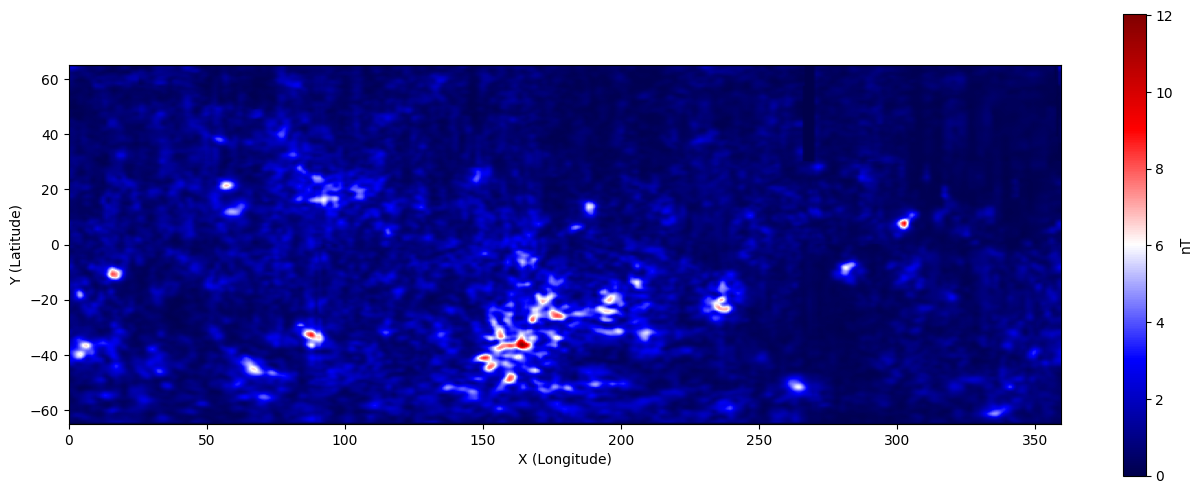

In [4]:
# Obter valores sem repetição de X e Y
x_unique = np.unique(dados['Longitude'])
y_unique = np.unique(dados['Latitude'])

# Criar um grid com base nesses valores únicos
grid_x, grid_y = np.meshgrid(x_unique, y_unique)

grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

# Plotando o mapa com isolinhas
plt.figure(figsize=(16, 6))
plt.imshow(grid_z, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower',
           cmap='seismic', aspect='auto')
#plt.scatter(x, y, c=z, s=30, cmap='magma')
plt.colorbar(label='nT')

#contours = plt.contour(grid_x, grid_y, grid_z, levels=12, colors='black') #Adicione linhas de contornos se quiser!!!
#plt.clabel(contours, inline=True, fontsize=8)
plt.xlabel('X (Longitude)')
plt.ylabel('Y (Latitude)')

plt.gca().set_aspect('equal')
plt.show()

Outras formas de exibição das cores, de acordo com o padrão de distribuição de valores. Aqui estou tentanod uma distribuição normal, ao invés da linear. Isto porque, na distribuição linear, poucos valores altos podem "puxar" muitas cores na sua direção, deixando as anomalias mais suaves quase invisíveis!

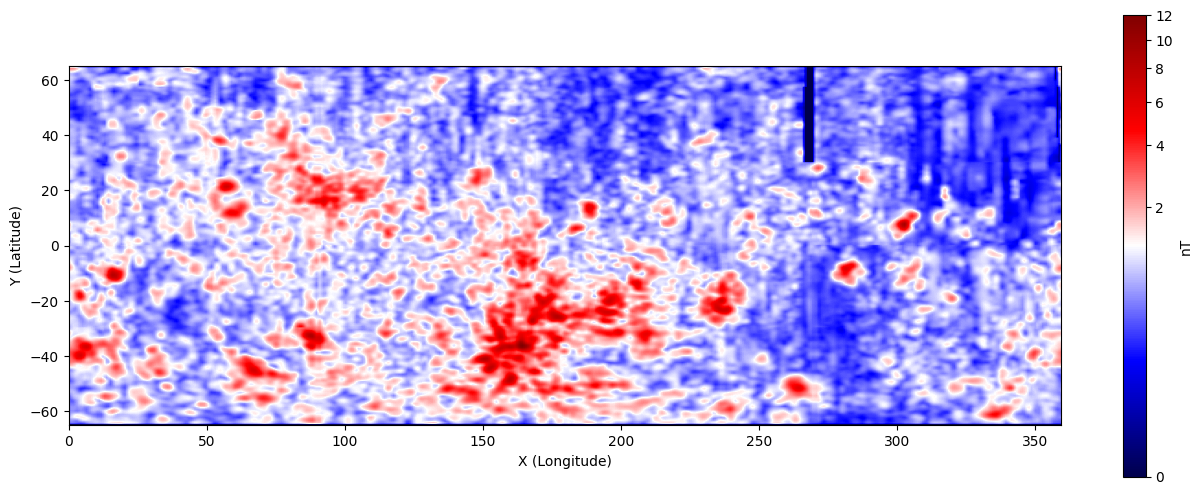

In [5]:
from matplotlib.colors import LogNorm, PowerNorm

# Ou usando uma normalização de potência
plt.figure(figsize=(16, 6))
plt.imshow(grid_z, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower',
           cmap='seismic', aspect='auto', norm=PowerNorm(gamma=0.3))
plt.colorbar(label='nT')
#contours = plt.contour(grid_x, grid_y, grid_z, levels=12, colors='black')
#plt.clabel(contours, inline=True, fontsize=8)
plt.xlabel('X (Longitude)')
plt.ylabel('Y (Latitude)')
plt.gca().set_aspect('equal')
plt.show()


Note que há um retângulo escuro na porção superior direita. Isso não é algo geológico não é mesmo? Vamos tentar suavizar isso?

**"Como vamos retirar esse retângulo Profe?"** Retirar, retirar, é complicado. Mais fácil seria recortar e assumir a perda! Mas atenuar esse erro é bem possível, e vamo fazer!

Vejam que, além do retângulo, o dado possui feições lineares de direção norte-sul, isso também não parece geológico, certo? É um tipo de ruído sistemático. Então. vamos pedir ao programa para atenuar as altas frequencias com direção norte-sul, a seguir.

Vamos começar do zero, aqui, desde carregar o dado até filtrar o ruído, para vocês observarem o processo todo no código.

#**2. Tratamento dos dados - Atenuar ruído**
Aqui vamos usar uma técnica de realce para atenuar ruídos de alta frequencia na direção norte-sul.

* **PROPÓSITO: retirar altas frequências com direção norte-sul.**

* TÉCNICA DE REALCE: um tipo de filtro passa-baixa, mas em uma direção específica (passarão baixas frequências, serão barradas as altas frequencias). MASSS, dessa vez, ao invés de cortar pelo tamanho da onda, vamos cortar pelo azimute. Então, dizemos que esse é um filtro *direcional*. Como a análise é com cossenos, o nome completo é "*filtro de cosseno direcional*".

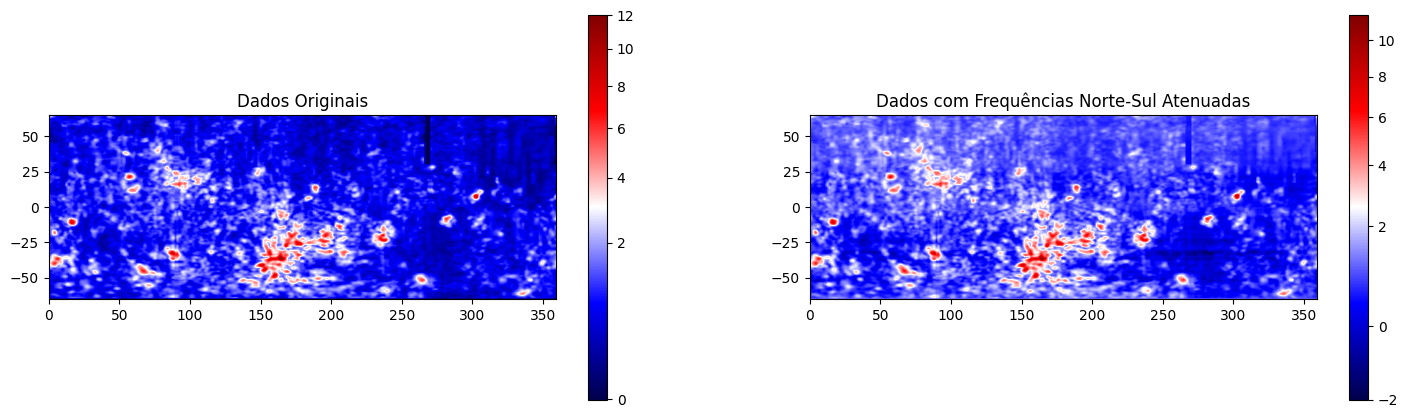

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from scipy.interpolate import griddata

# Carregar os dados do arquivo CSV
file_path = 'Bm_30km_65S65N_0E360E.csv'
dados = pd.read_csv(file_path)
x = dados['Longitude'].values
y = dados['Latitude'].values
z = dados['B-Mag'].values

# Criar um raster (grid)
x_unique = np.unique(x) #separo os valores x
y_unique = np.unique(y) #separo os valores y
grid_x, grid_y = np.meshgrid(x_unique, y_unique) #criar grids x e y
grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic') # criar grid z com o endereço dado pelos grids x e y

nx, ny = grid_z.shape #pega o número de valores em x e em y
dx = np.abs(x_unique[1] - x_unique[0]) # obter a distância entre um ponto e outro (tamanho)
dy = np.abs(y_unique[1] - y_unique[0]) # obter a distância entre um ponto e outro (tamanho)



##### PASSANDO PARA O DOMÍNIO DA FREQUENCIA #####
# Transformada de Fourier (fft2 é a FFT para dados 2D)
gridfft = fft2(grid_z)
gridfft_shifted = fftshift(gridfft)  # Centraliza o espectro de zero frequência

# Parâmetros do filtro
azimuth_center = 0  # Azimute central do filtro, em graus
azimuth_range = 2  # Margem em graus, para retirar tambem

##### FILTRO DENTRO DO DOM. DA FREQUENCIA #####
# Aplicar o filtro baseado no ângulo
for j in range(nx):
    for i in range(ny):
        kx = (i - ny//2) * (2 * np.pi / nx) / dx
        ky = (j - nx//2) * (2 * np.pi / ny) / dy
        angle = np.degrees(np.arctan2(ky, kx))  # Ângulo da frequência em graus

        # Verificar se está dentro do intervalo ao redor de 90 graus
        if abs(angle - (azimuth_center+90)) <= azimuth_range or abs(angle - (azimuth_center-90)) <= azimuth_range:
            gridfft_shifted[j, i] = 0  # Zerar as frequências na faixa especificada

##### PASSANDO PARA O DOMÍNIO DO ESPAÇO #####
# IFFT
gridfft = ifftshift(gridfft_shifted)
grid_z_filtrado = ifft2(gridfft).real



##### MUNDO REAL ######
# Plotar os resultados
plt.figure(figsize=(18, 5))
plt.subplot(121)
plt.imshow(grid_z, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='seismic', norm=PowerNorm(gamma=0.5))
plt.title('Dados Originais')
plt.colorbar()

plt.subplot(122)
plt.imshow(grid_z_filtrado, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='seismic', norm=PowerNorm(gamma=0.5))
plt.title('Dados com Frequências Norte-Sul Atenuadas')
plt.colorbar()
plt.show()

#**3. Salvar um CSV de saída**

Dados salvos em bmag_filtrado.csv


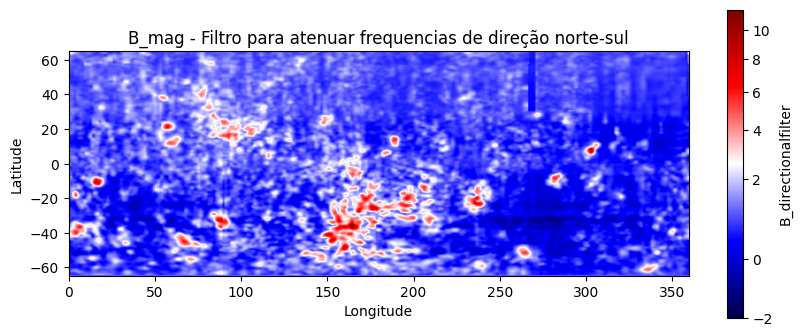

In [7]:
# Salvar dados grid_z_filtrado em csv, com coluna x, y, B_mag, B_directionalfilter

import pandas as pd

# DataFrame da biblioteca Pandas com as colunas escolhidas
df = pd.DataFrame({
    'x': grid_x.flatten(),
    'y': grid_y.flatten(),
    'B_mag': grid_z_filtrado.flatten(),
    'B_directionalfilter': grid_z_filtrado.flatten()  # Replace with the actual filtered data if different
})

# Save the DataFrame to a CSV file
df.to_csv('bmag_filtrado.csv', index=False)

print("Dados salvos em bmag_filtrado.csv")


# Plotar dado exportado para conferir...

import matplotlib.pyplot as plt

df = pd.read_csv('bmag_filtrado.csv')
x = df['x'].values
y = df['y'].values
z = df['B_directionalfilter'].values

grid_x, grid_y = np.meshgrid(np.unique(x), np.unique(y))
grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

plt.figure(figsize=(10, 4))
plt.imshow(grid_z, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='seismic', norm=PowerNorm(gamma=0.5))
plt.colorbar(label='B_directionalfilter')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('B_mag - Filtro para atenuar frequencias de direção norte-sul')
plt.show()